In [8]:
#Python version
!python --version

Python 3.6.13 :: Anaconda, Inc.


In [9]:
#Install uninstalled modules, comment if it's already installed

#!pip install tensorflow==1.15 finta stable-baselines MetaTrader5 gym gym-anytrading quantstats

In [10]:
#Import needed modules
import gym
import gym_anytrading
from gym_anytrading.envs import ForexEnv

import numpy as np
import quantstats as qs

from stable_baselines.a2c import A2C
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpLstmPolicy
from stable_baselines.common.callbacks import EvalCallback

import matplotlib.pyplot as plt
import pandas as pd
from finta import TA

import datetime, os, pytz
import MetaTrader5 as mt5

In [11]:
#Trading Account Parameter
account = 647545 #Account number
password = "QpjpAGkK" #Password number
server = "FBS-Demo" #Server name
mt5_path = "C:\Program Files\FBS MetaTrader 5\terminal64.exe" #path of Metatrader5 director

mt5.initialize(
   path = mt5_path,          # path to the MetaTrader 5 terminal EXE file
   login = account,          # account number
   password = password,      # password
   server = server,          # server name as it is specified in the terminal
   #timeout = TIMEOUT,       # timeout
   portable = False          # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__,"\n")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")

# extract account information and turn it into dataframe   
authorized=mt5.login(account, password, server)
if authorized:
    # display trading account data 'as is'
    print("Metatrader5 authorized!")
    account_info_dict = mt5.account_info()._asdict()
    Acc_Info = pd.DataFrame(list(account_info_dict.items()),columns=['property','value'])
    print("\n", "account_info() as dataframe:")
    print(Acc_Info)
else:
    print("Metatrader5 cant authorize, error code: {}".format(mt5.last_error()))

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34 

MetaTrader5 Initialized!
Metatrader5 authorized!

 account_info() as dataframe:
              property             value
0                login            647545
1           trade_mode                 0
2             leverage              1000
3         limit_orders               100
4       margin_so_mode                 0
5        trade_allowed              True
6         trade_expert              True
7          margin_mode                 2
8      currency_digits                 2
9           fifo_close             False
10             balance            100000
11              credit                 0
12              profit                 0
13              equity            100000
14              margin                 0
15         margin_free            100000
16        margin_level                 0
17      margin_so_call                40
18        margin_so_so                20
19    

In [12]:
#Extract Account info from dataframe
leverage = Acc_Info.loc[2, "value"]
equity = Acc_Info.loc[13, "value"]
margin_free = Acc_Info.loc[15, "value"]

print(leverage)
print(equity)
print(margin_free)

1000
100000.0
100000.0


In [13]:
# extract information from pair and timeframe
Symbol = "EURUSD"
Timeframe = mt5.TIMEFRAME_M5
symbol_info = mt5.symbol_info(Symbol)
if symbol_info!=None:
    # display the terminal data 'as is'    
    print(symbol_info)
    print("\n","{}: spread =".format(Symbol),symbol_info.spread,"  digits =",symbol_info.digits, "\n")
    # Extract symbol info
    
    print(symbol_info[3])

SymbolInfo(custom=False, chart_mode=0, select=True, visible=True, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=1623350683, digits=5, spread=11, spread_float=True, ticks_bookdepth=0, trade_calc_mode=0, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=1, trade_freeze_level=0, trade_exemode=2, swap_mode=1, swap_rollover3days=3, margin_hedged_use_leg=False, expiration_mode=15, filling_mode=3, order_mode=127, order_gtc_mode=0, ...)

 EURUSD: spread = 11   digits = 5 

True


In [14]:
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")

# getbars from the current day
bar = 6000
rates = mt5.copy_rates_from_pos(Symbol, Timeframe, 0, bar)
 
# create DataFrame out of the obtained data
rates_frame = pd.DataFrame(rates, dtype=np.dtype("float"))
# convert time in seconds into the datetime format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
                           
# display data
print("\nDisplay dataframe with data")
print(rates_frame)

# turn rates frame into csv file
rates_frame.to_csv('./Datasets/{}.csv'.format(Symbol), index=False)
pd.read_csv('./Datasets/{}.csv'.format(Symbol))


Display dataframe with data
                    time     open     high      low    close  tick_volume  \
0    2021-05-21 19:55:00  1.21686  1.21690  1.21614  1.21648        367.0   
1    2021-05-21 20:00:00  1.21647  1.21689  1.21633  1.21689        226.0   
2    2021-05-21 20:05:00  1.21689  1.21702  1.21677  1.21691        209.0   
3    2021-05-21 20:10:00  1.21689  1.21712  1.21689  1.21697        150.0   
4    2021-05-21 20:15:00  1.21697  1.21704  1.21682  1.21687        137.0   
...                  ...      ...      ...      ...      ...          ...   
3995 2021-06-10 18:20:00  1.21687  1.21687  1.21650  1.21675        229.0   
3996 2021-06-10 18:25:00  1.21672  1.21690  1.21626  1.21643        221.0   
3997 2021-06-10 18:30:00  1.21642  1.21671  1.21642  1.21664        232.0   
3998 2021-06-10 18:35:00  1.21663  1.21697  1.21663  1.21686        253.0   
3999 2021-06-10 18:40:00  1.21686  1.21734  1.21639  1.21662        309.0   

      spread  real_volume  
0        8.0      

,time,open,high,low,close,tick_volume,spread,real_volume
0,2021-05-21 19:55:00,1.21686,1.21690,1.21614,1.21648,367.0,8.0,0.0
1,2021-05-21 20:00:00,1.21647,1.21689,1.21633,1.21689,226.0,8.0,0.0
2,2021-05-21 20:05:00,1.21689,1.21702,1.21677,1.21691,209.0,9.0,0.0
3,2021-05-21 20:10:00,1.21689,1.21712,1.21689,1.21697,150.0,8.0,0.0
4,2021-05-21 20:15:00,1.21697,1.21704,1.21682,1.21687,137.0,9.0,0.0
...,...,...,...,...,...,...,...,...
3995,2021-06-10 18:20:00,1.21687,1.21687,1.21650,1.21675,229.0,9.0,0.0
3996,2021-06-10 18:25:00,1.21672,1.21690,1.21626,1.21643,221.0,7.0,0.0
3997,2021-06-10 18:30:00,1.21642,1.21671,1.21642,1.21664,232.0,9.0,0.0
3998,2021-06-10 18:35:00,1.21663,1.21697,1.21663,1.21686,253.0,9.0,0.0


In [17]:
# read csv from datasets folder
df = pd.read_csv('./Datasets/{}.csv'.format(Symbol))

# turn time coloumn into datetime
df['time'] = pd.to_datetime(df['time'])

#delete empty coloumn
del df['real_volume']

# make indicator coloumns to the dataframe
df['EMA'] = TA.EMA(df, 100, 'open')
df['RSI'] = TA.RSI(df, 14, 'open')
df['ATR'] = TA.ATR(df, 14)
df.fillna(0, inplace=True)

#  rename coloumn's name
df = df.rename(columns={
    "time":"Date",
    "open":"Open",
    "high":"High",
    "low":"Low",
    "close":"Close",
    "tick_volume":"Tick_volume",
    "spread":"Spread",
})

# set Date coloumn as index
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Tick_volume,Spread,EMA,RSI,ATR
Date,,,,,,,,,
2021-05-21 19:55:00,1.21686,1.21690,1.21614,1.21648,367.0,8.0,1.216860,0.000000,0.000000
2021-05-21 20:00:00,1.21647,1.21689,1.21633,1.21689,226.0,8.0,1.216663,0.000000,0.000000
2021-05-21 20:05:00,1.21689,1.21702,1.21677,1.21691,209.0,9.0,1.216740,53.698630,0.000000
2021-05-21 20:10:00,1.21689,1.21712,1.21689,1.21697,150.0,8.0,1.216779,53.698630,0.000000
2021-05-21 20:15:00,1.21697,1.21704,1.21682,1.21687,137.0,9.0,1.216819,58.608646,0.000000
...,...,...,...,...,...,...,...,...,...
2021-06-10 18:20:00,1.21687,1.21687,1.21650,1.21675,229.0,9.0,1.217331,41.607667,0.000516
2021-06-10 18:25:00,1.21672,1.21690,1.21626,1.21643,221.0,7.0,1.217319,40.309986,0.000526
2021-06-10 18:30:00,1.21642,1.21671,1.21642,1.21664,232.0,9.0,1.217301,37.772603,0.000519


In [18]:
# make a custom signal parameter from a spesific data
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Open'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open', 'EMA', 'RSI', 'ATR']].to_numpy()[start:end]
    return prices, signal_features

class MyCustomEnv(ForexEnv):
    _process_data = add_signals


env information:
> shape: (10, 4)
> df.shape: (4000, 9)
> prices.shape: (4000,)
> signal_features.shape: (4000, 4)
> max_possible_profit: 1.0029349658779414


> possible action: Discrete(2)
> observation space: Box(-inf, inf, (10, 4), float32)


> signal features:  [[1.21686000e+00 1.21686000e+00 0.00000000e+00 0.00000000e+00]
 [1.21647000e+00 1.21666305e+00 0.00000000e+00 0.00000000e+00]
 [1.21689000e+00 1.21674022e+00 5.36986301e+01 0.00000000e+00]
 ...
 [1.21642000e+00 1.21730113e+00 3.77726034e+01 5.19285714e-04]
 [1.21663000e+00 1.21728784e+00 4.05916581e+01 4.94285714e-04]
 [1.21686000e+00 1.21727936e+00 4.36050479e+01 5.26428571e-04]]


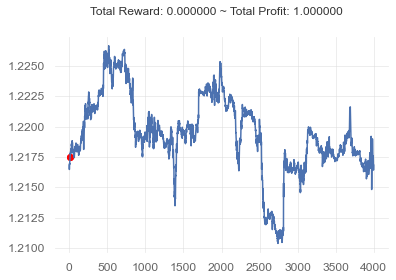

In [19]:
# build the gym environment
window_size = 12
start_index = window_size
end_index = len(df)
env = MyCustomEnv(df = df,
               window_size = start_index,
               frame_bound = (start_index, end_index), #Max 6225 Rows of data
               unit_side = 'right')

seed = 42
env.seed(seed)
eps = np.finfo(np.float32).eps.item()

# get information from the environment
print()
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())
print("\n")
print("> possible action:", env.action_space)
print("> observation space:", env.observation_space)
print("\n")
print("> signal features: ", env.signal_features)

env.reset() # Uncomment if you need it.
env.render()

print(env.df)
print("\n")
env.df.info()

info: {'total_reward': -145.3999999998733, 'total_profit': 0.7784089713097953, 'position': 1}


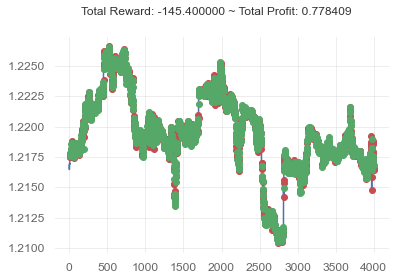

Date
2021-05-21 20:55:00    0.000000
2021-05-21 21:00:00   -0.000156
2021-05-21 21:05:00    0.000000
2021-05-21 21:10:00    0.000000
2021-05-21 21:15:00   -0.000255
                         ...   
2021-06-10 18:20:00    0.000000
2021-06-10 18:25:00    0.000000
2021-06-10 18:30:00   -0.000616
2021-06-10 18:35:00    0.000000
2021-06-10 18:40:00    0.000000
Length: 3988, dtype: float64 



                           Strategy
-------------------------  ----------
Start Period               2021-05-21
End Period                 2021-06-10
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -22.16%
CAGR%                      -99.19%

Sharpe                     -5.69
Sortino                    -5.75
Sortino/√2                 -4.07

Max Drawdown               -22.16%
Longest DD Days            19
Volatility (ann.)          0.28%
Calmar                     -4.48
Skew                       -0.78
Kurtosis                   32.82

Expected Daily %           -0.01%
Expected Monthly %         -11.77%
Expected Yearly %          -22.16%
Kelly Criterion            -106.58%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.04%
Expected Shortfall (cVaR)  -0.04%

Gain/Pain Ratio            -1.0
Gain/Pain (1M)             -1.0

Payoff Ratio               0.76
Profit Factor              0.09
Common Sense Ratio         0.0
CPC Index     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-05-21,2021-06-10,2021-06-10,19,-22.159103,-21.786504


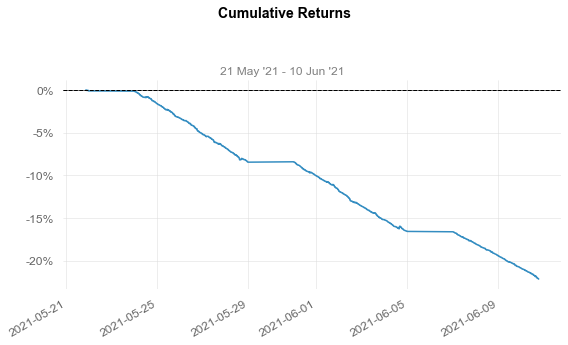

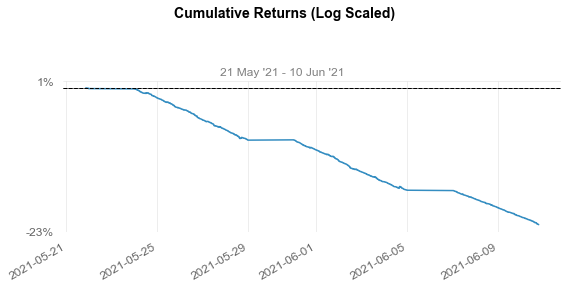

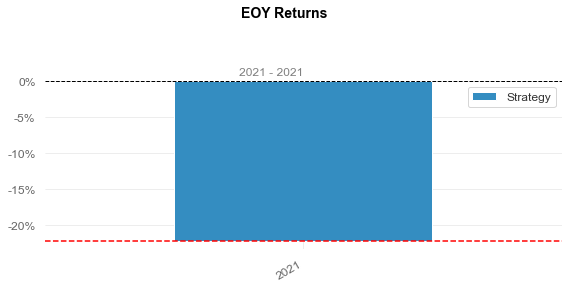

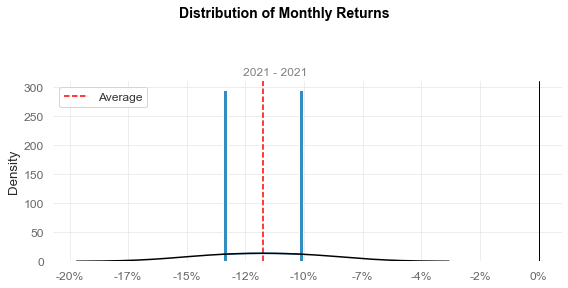

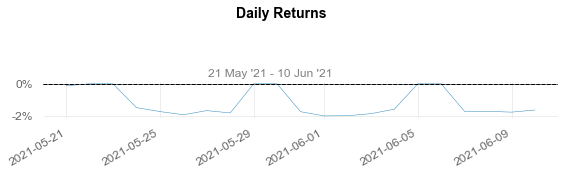

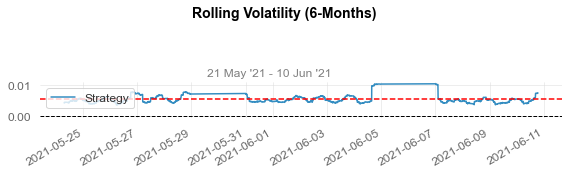

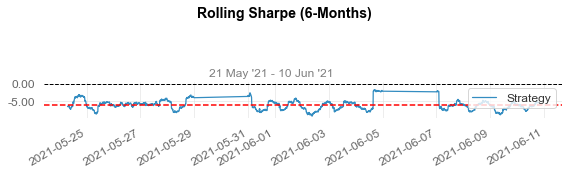

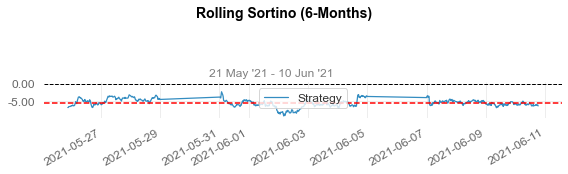

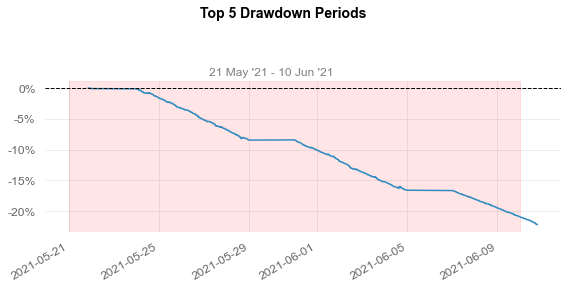

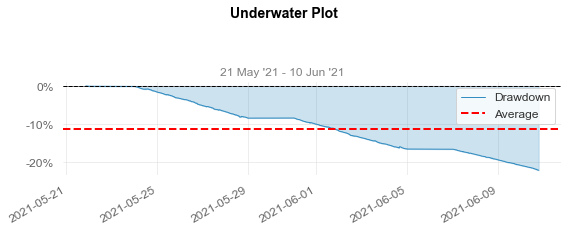

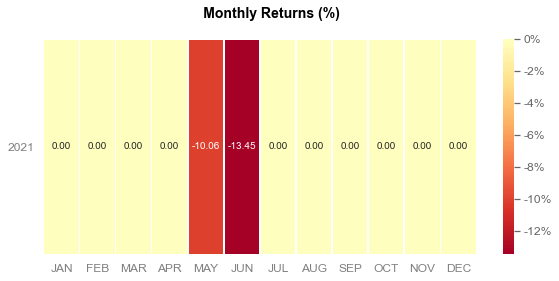

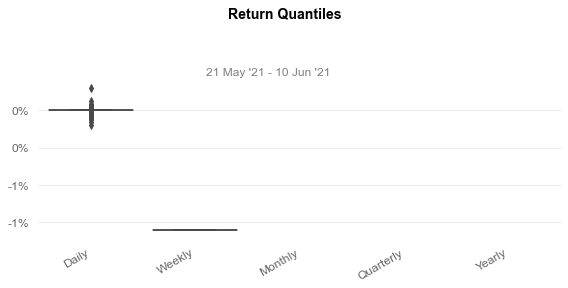

In [21]:
# make a prediction based on random actions

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

# create a quantstats result for a comparison
qs.extend_pandas()
net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns,'\n')

qs.reports.full(returns)
qs.reports.html(returns, output='./Random Result/random quantstats.html'.format(Symbol, Timeframe))

In [22]:
env_maker = lambda: env
env = DummyVecEnv([env_maker])

In [202]:
eval_callback = EvalCallback(env, best_model_save_path='./Saved_Model/{}-{}-Model'.format(Symbol, Timeframe),
                             log_path='./logs/{}_{}'.format(Symbol, Timeframe), eval_freq=500,
                             deterministic=True, render=False)
timesteps = 1000000

policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs) 
model.learn(total_timesteps=timesteps, callback=eval_callback)

300    |
| policy_entropy     | 0.000141 |
| total_timesteps    | 441500   |
| value_loss         | 8.14e-11 |
---------------------------------
Eval num_timesteps=442000, episode_reward=0.40 +/- 0.00
Episode length: 3989.00 +/- 0.00
---------------------------------
| explained_variance | -0.0091  |
| fps                | 28       |
| nupdates           | 88400    |
| policy_entropy     | 0.000142 |
| total_timesteps    | 442000   |
| value_loss         | 8.5e-11  |
---------------------------------
Eval num_timesteps=442500, episode_reward=0.40 +/- 0.00
Episode length: 3989.00 +/- 0.00
---------------------------------
| explained_variance | -0.0156  |
| fps                | 28       |
| nupdates           | 88500    |
| policy_entropy     | 0.000142 |
| total_timesteps    | 442500   |
| value_loss         | 8.61e-11 |
---------------------------------
Eval num_timesteps=443000, episode_reward=0.40 +/- 0.00
Episode length: 3989.00 +/- 0.00
---------------------------------
| explaine

KeyboardInterrupt: 

In [24]:
# delete model dan loading from saved folder, comment if you didn't need it
## del model # remove model to demonstrate saving and loading
## model = A2C.load('./Saved_Model/{}-{}-Model'.format(Symbol, Timeframe), env=env)
## model = A2C.load('D:\TugasKampus\Fun Project\MT5_TensorDL\Saved_Model\EURUSD-5-Model\model.zip')

env = MyCustomEnv(df = df,
               window_size = start_index,
               frame_bound = (start_index, end_index), #Max 6225 Rows of data
               unit_side = 'right')

observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    if done:
        print("info:", info)
        break

ValueError: Error: Unexpected observation shape (1, 1, 10, 4) for Box environment, please use (10, 4) or (n_env, 10, 4) for the observation shape.

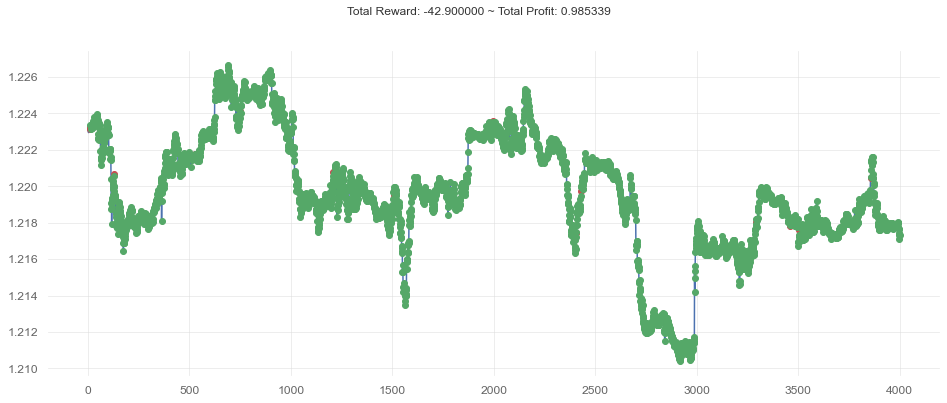

In [228]:
# gets result from trained model
plt.figure(figsize=(24, 8))
env.render_all()
plt.show()

Date
2021-05-21 06:25:00    0.000000
2021-05-21 06:30:00   -0.000278
2021-05-21 06:35:00    0.000000
2021-05-21 06:40:00    0.000000
2021-05-21 06:45:00    0.000000
                         ...   
2021-06-10 03:50:00    0.000000
2021-06-10 03:55:00    0.000000
2021-06-10 04:00:00    0.000000
2021-06-10 04:05:00    0.000000
2021-06-10 04:10:00   -0.002835
Length: 3988, dtype: float64 



                           Strategy
-------------------------  ----------
Start Period               2021-05-21
End Period                 2021-06-10
Risk-Free Rate             0.0%
Time in Market             1.0%

Cumulative Return          -1.47%
CAGR%                      -24.7%

Sharpe                     -0.3
Sortino                    -0.34
Sortino/√2                 -0.24

Max Drawdown               -1.59%
Longest DD Days            19
Volatility (ann.)          0.31%
Calmar                     -15.51
Skew                       -16.23
Kurtosis                   655.36

Expected Daily %           -0.0%
Expected Monthly %         -0.74%
Expected Yearly %          -1.47%
Kelly Criterion            -36.55%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.03%
Expected Shortfall (cVaR)  -0.03%

Gain/Pain Ratio            -0.56
Gain/Pain (1M)             -1.0

Payoff Ratio               0.68
Profit Factor              0.55
Common Sense Ratio         nan
CPC Index          

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-05-21,2021-06-04,2021-06-10,19,-1.592821,-1.470923


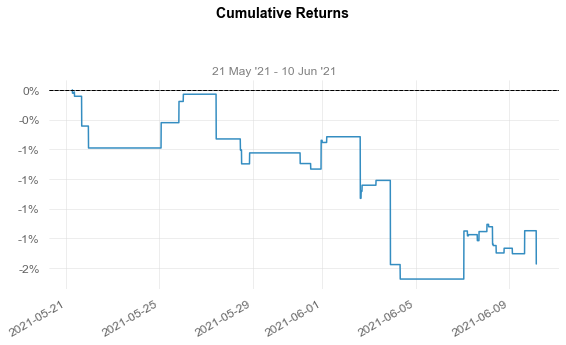

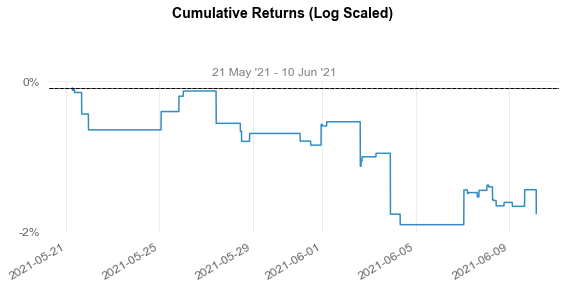

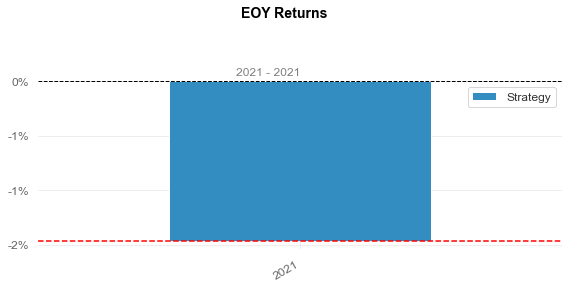

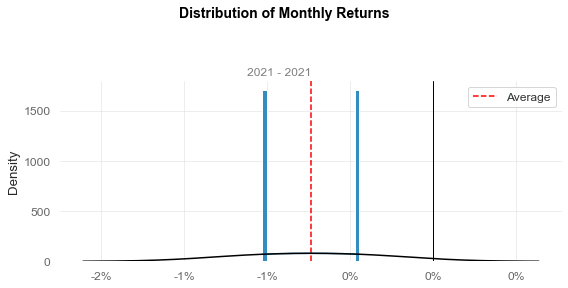

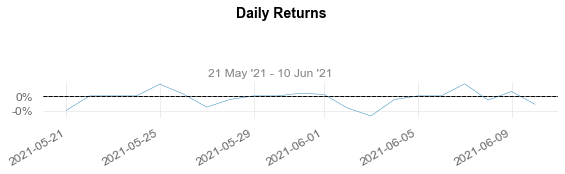

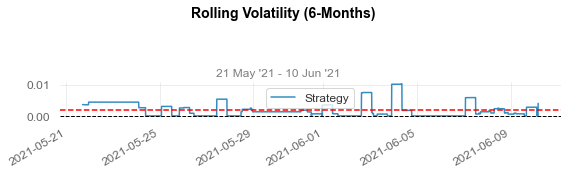

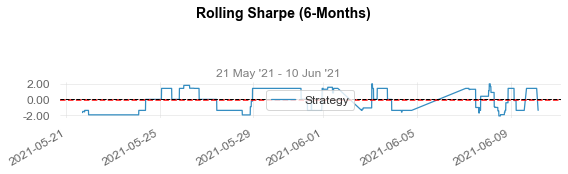

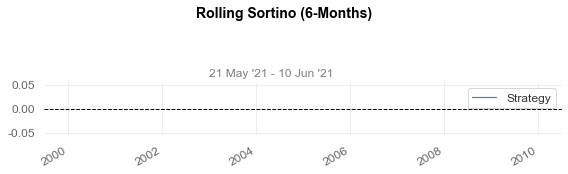

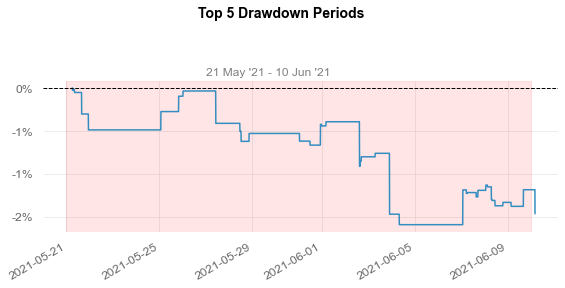

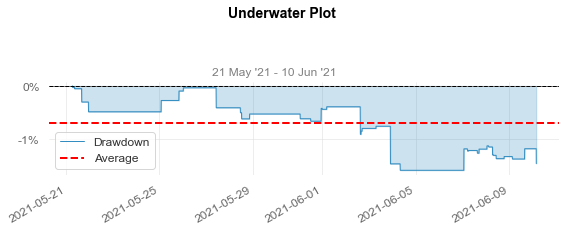

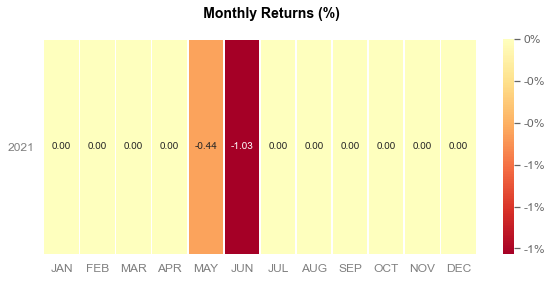

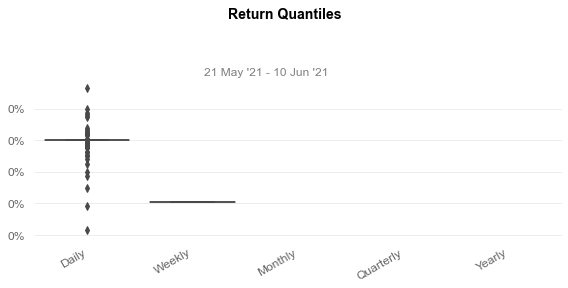

In [230]:
# gets full result from trained model
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns,'\n')

qs.reports.full(returns)
qs.reports.html(returns, output='./Backtesting/{}_{}_quantstats.html'.format(Symbol, Timeframe))